In [93]:
import numpy as np
from boto.s3.connection import S3Connection
from boto.s3.key import Key
import boto
import sys, os
import pandas as pd
from textblob import Blobber
from textblob_aptagger import PerceptronTagger
import re
import editdistance
import datetime
import subprocess
# from selenium import webdriver
# from selenium.webdriver.support.ui import Select
# from selenium.webdriver.common import action_chains, keys
# from selenium import webdriver
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC

# from pyvirtualdisplay import Display
# import gnp
# import codecs
# import json
import numpy as np
from boto.s3.connection import S3Connection
from boto.s3.key import Key
import boto
import sys, os
import pandas as pd
# from TwitterSearch import *
# from sunlight import congress
# from bs4 import BeautifulSoup
# import urllib2
# import itertools
# import datetime
# import configparser
# import time
from pattern.en import parsetree
from pattern.en import mood
import dateutil.parser as dparser
import sunlight
from sunlight import congress
import re
from postal.parser import parse_address
import csv
import selenium
from bs4 import BeautifulSoup as soupy
import tweepy
import codecs
import io
import phonenumbers
import re
import editdistance
import nltk
from geopy.geocoders import Nominatim
import address
from address import AddressParser, Address

# import geotext
# from geotext import GeoText
# import geograpy
# import pprint
# import ner
# from nltk.tag import StanfordNERTagger
# from nltk.tokenize import word_tokenize
# import editdistance
import calendar
# from itertools import islice
# from nltk.chunk import conlltags2tree, tree2conlltags, ne_chunk
# import nltk

# def take(n, iterable):
#     "Return first n items of the iterable as a list"
#     return list(islice(iterable, n))

import spacy
nlp = spacy.load('en')

from sklearn import metrics
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [49]:
from issues_actions import (
    issues,
    actions,
    state_regex,
    city_regex,
    web_url_regex,
    date_include_regex,
    date_exclude_regex,
    leg_name_regex,
    leg_twitter_regex,
    profanity_regex
)

In [2]:
today = datetime.date.today()
yr = str(today.year)[-2:]
mnth = today.month
if len(str(mnth)) == 1:
    mnth = '0' + str(mnth)
else:
    mnth = str(mnth)
day = today.day
if len(str(day)) == 1:
    day = '0' + str(day)
else:
    day = str(day)

url = "s3://mids-capstone-rzst/es_staging/" + str(yr) + '.' + str(mnth) + '.' + str(day) + '/es_data.csv'


In [3]:
full_dataset = pd.read_csv('~/w210_imwithdata/data/bucket_stuff/es_data.csv')
print full_dataset.columns
tb = Blobber(pos_tagger=PerceptronTagger())
print len(full_dataset)

Index([u'issue', u'action', u'id', u'es_score', u'tweet_timestamp',
       u'query_timestamp', u'tweet_user', u'tweet_cities', u'tweet_states',
       u'tweet_urls', u'tweet_phone_numbers', u'tweet_dates_ref',
       u'tweet_legislator_names', u'tweet_legislator_handles', u'tweet'],
      dtype='object')
21256


In [72]:
test_data = pd.read_csv('~/w210_imwithdata/data/static_data/full_rzst_test_dataset.csv')
test_data['tweet'] = test_data['tweet'].str.decode('latin-1').str.encode('utf-8').replace('\s+',' ').str.strip()
print len(test_data)
print test_data.columns
print test_data['actionable'].sum()

16634
Index([u'issue', u'action', u'id', u'es_score', u'tweet_timestamp',
       u'query_timestamp', u'tweet_user', u'tweet', u'actionable'],
      dtype='object')
2608


In [73]:
all_phones = []
all_states = []
all_cities = []
all_urls = []
all_dates = []
all_leg_names = []
all_leg_twitter_handles = []

for tweet in test_data['tweet'].tolist(): 
    # EXTRACT PHONE NUMBER, URL, STATE, CITY, DATE, LEGISLATOR NAMES, AND LEGISLATOR TWITTER HANDLES #
    # -- Phone Numbers -- #
    phone_numbers = []
    if phonenumbers.PhoneNumberMatcher(tweet.decode('latin-1'), "US"):
        for match in phonenumbers.PhoneNumberMatcher(tweet.decode('latin-1'), "US"):
                    phone_numbers.append(phonenumbers.format_number(match.number,
                                                                    phonenumbers.PhoneNumberFormat.NATIONAL))
    all_phones.append(phone_numbers)            
    
    # -- States -- #
    states = []
    if state_regex.match(tweet):
        for match in re.findall(state_regex, tweet):
            states.append(match)
    all_states.append(states)

    # -- CITIES -- #
    cities = []
    if city_regex.match(tweet):
        for match in re.findall(city_regex, tweet):
            if match != 'White House' and match != 'Liberal' and match != 'Perry' and match != 'Price':
                cities.append(match)
    all_cities.append(cities)

    # -- URLS -- #
    urls = []
    if re.findall(web_url_regex,tweet):
        urls.append(re.findall(web_url_regex, tweet))
    all_urls.append(urls)

    # -- DATES -- #
    dates = []
    # SPACY NLP
    doc = nlp(tweet.decode('latin-1'))
    # ITERATING THROUGH ENTITIES FROM SPACY
    for ent in doc.ents:
        ### EXCLUDE SOME DIRTY DATES FROM TWITTER THAT SPACY MISTAKENLY INCLUDES
        if ent.label_ == u'DATE':
            if re.findall(date_exclude_regex,ent.text):
                pass
            elif re.findall(date_include_regex, ent.text) and 'weeks' not in ent.text and 'months' not in ent.text and 'old' not in ent.text:
                dates.append(ent.text)
    all_dates.append(dates)

    # -- LEGISLATOR NAMES -- #
    leg_names = []
    if leg_name_regex.match(tweet):
        for match in re.findall(leg_name_regex, tweet):
            leg_names.append(match)
    all_leg_names.append(leg_names)

    # -- LEGISLATOR TWITTER HANDLES -- #
    leg_twitter_handles = []
    if leg_twitter_regex.match(tweet):
        for match in re.findall(leg_twitter_regex, tweet):
            leg_twitter_handles.append(match)
    all_leg_twitter_handles.append(leg_twitter_handles)
    

In [74]:
print len(all_phones)
print len(all_states)
print len(all_cities)
print len(all_urls)
print len(all_dates)
print len(all_leg_names)
print len(all_leg_twitter_handles)
print len(test_data)

16634
16634
16634
16634
16634
16634
16634
16634


In [75]:
test_data['tweet_phone_numbers'] = np.asarray(all_phones)
test_data['tweet_states'] = np.asarray(all_states)
test_data['tweet_cities'] = np.asarray(all_cities)
test_data['tweet_urls'] = np.asarray(all_urls)
test_data['tweet_dates_ref'] = np.asarray(all_dates)
test_data['tweet_legislator_names'] = np.asarray(all_leg_names)
test_data['tweet_legislator_handles'] = '[]'

In [76]:
test_data = test_data[['issue','action','tweet','es_score','tweet_timestamp','tweet_cities','tweet_states','tweet_urls'
                                      ,'tweet_phone_numbers','tweet_dates_ref','tweet_legislator_names','tweet_legislator_handles','actionable']]
test_data.columns

Index([u'issue', u'action', u'tweet', u'es_score', u'tweet_timestamp',
       u'tweet_cities', u'tweet_states', u'tweet_urls', u'tweet_phone_numbers',
       u'tweet_dates_ref', u'tweet_legislator_names',
       u'tweet_legislator_handles', u'actionable'],
      dtype='object')

In [33]:
actionability_ranking = full_dataset[['issue','action','tweet','es_score','tweet_timestamp','tweet_cities','tweet_states','tweet_urls'
                                      ,'tweet_phone_numbers','tweet_dates_ref','tweet_legislator_names','tweet_legislator_handles']]

# actionability_ranking[:10]

# print actionability_ranking.action.unique()

In [77]:
## CREATE EMPTY LIST FOR SCORES FROM TEXT ANALYSIS
language_scores = []
### WE DONT WANT PAST TENSE VERBS AND ADVERBS INDICATE NEWS
bad_verbs = ['VBZ','VBN','VBD','RB']
good_verbs = ['VB','VBG','VBP','JJ']


### Part of speech tag each tweet
for tweet in test_data['tweet'].tolist():
    tagged = tb(tweet.decode('latin-1').lower())
    tag_list = [x[1] for x in tagged.tags]
    score = 0
    
    ### Penalize tweets with structures that are known to be not what we're looking for
    ### POS Tags available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    if tag_list[:2] == ['NNP','POS',]:
        score -= 4
    if tag_list[:3] == ['NN', 'POS','NN']:
        score -= 10
    if tag_list[:3] == ['NN', 'NN', 'TO']:
        score -= 10
    if tag_list[:3] == ['NN', 'TO', 'VB']:
        score -= 10
    if tag_list[:3] == ['NN', 'NN', 'VBZ']:
        score -= 10
    if tag_list[:3] == ['NN', 'NN', 'JJ']:
        score -= 10
    if tag_list[:3] == ['NN', 'JJ', 'NN']:
        score -= 10
    
    if tag_list[:3] == ['JJ', 'NNS', 'VBP']:
        score -= 4
    elif tag_list[:3] == ['JJ', 'NN', 'VBG']:
        score -= 4
    elif tag_list[:3] == ['JJS', 'NN', 'JJ']:
        score -= 4
    elif tag_list[:3] == ['NN', 'NN', 'NN']:
        score -= 4
    elif tag_list[:3] == ['JJ', 'NN', 'NN']:
        score -= 4
    elif tag_list[:3] == ['JJ', 'NN', 'NNS']:
        score -= 4
    elif tag_list[:3] == ['JJ', 'NN', 'VB']:
        score -= 10
    elif tag_list[:3] == ['IN', 'JJ', 'NN']:
        score -= 10
    elif tag_list[0] == 'JJ':
        score += 3
        
    if tag_list[0] == 'VB':
        score += 4
    
    
    #### Penalize tweets with words in them that indicate they are not useful
    if 'yesterday' in tweet.lower():
        score -= 10
    if 'last week' in tweet.lower():
        score -= 10
    if 'video' in tweet.lower():
        score -= 10
    if 'news search' in tweet.lower():
        score -= 10
    if 'town hall in facebook' in tweet.lower():
        score -= 20
    if 'townhall in facebook' in tweet.lower():
        score -= 20
    if "facebook's" in tweet.lower() and "town hall" in tweet.lower():
        score -= 20
    if 'cnn town hall' in tweet.lower():
        score -= 20
    if 'online  paper' in tweet.lower():
        score -= 20
    if 'join us' in tweet.lower():
        score -= 10
    if 'sales' in tweet.lower():
        score -= 20
    if 'relaxing' in tweet.lower():
        score -= 20
    if 'canada' in tweet.lower():
        score -= 20
    if 'minister' in tweet.lower():
        score -= 20
    if 'UK' in tweet:
        score -= 20
    if 'MP' in tweet:
        score -= 20
    if 'EU' in tweet:
        score -= 20
    if 'england' in tweet.lower():
        score -= 20 
    if 'germany' in tweet.lower():
        score -= 20 
    if 'south africa' in tweet.lower():
        score -= 20 
    if 'News' in tweet:
        score -= 10
    if 'Daily Beast' in tweet.lower():
        score -= 20
    if '#design' in tweet.lower():
        score -= 20
    if '#interior' in tweet.lower():
        score -= 20
    if 'radicalisation' in tweet.lower():
        score -= 20
    if 'militancy' in tweet.lower():
        score -= 20
    if 'sharia' in tweet.lower():
        score -= 20
    if 'uncontrolled' in tweet.lower():
        score -= 20
    if 'enjoy a' in tweet.lower():
        score -= 20
    if tweet.lower().startswith('the latest'):
        score -= 20
    if 'wapo' in tweet.lower():
        score -= 20
    if 'nytimes' in tweet.lower():
        score -= 20
    if '@cnnpolitics' in tweet.lower():
        score -= 20
    if '@caretoclick' in tweet.lower():
        score -= 20
    if '5 things' in tweet.lower():
        score -= 20
    if 'poland' in tweet.lower():
        score -= 20
    if 'hungary' in tweet.lower():
        score -= 20
    if 'slovakia' in tweet.lower():
        score -= 20
    if 'czech' in tweet.lower():
        score -= 20
    if 'austria' in tweet.lower():
        score -= 20
    if 'india' in tweet.lower():
        score -= 20
    if 'france' in tweet.lower():
        score -= 20
    if 'clown' in tweet.lower():
        score -= 20
    if 'clever app' in tweet.lower():
        score -= 20
    if 'new app' in tweet.lower():
        score -= 20
    if 'from fox' in tweet.lower():
        score -= 20
    if tweet.lower().startswith('new york,'):
        score -= 20
    if tweet.lower().startswith('washington,'):
        score -= 20
    if tweet.lower().startswith('los angeles,'):
        score -= 20
    if tweet.lower().startswith('dallas,'):
        score -= 20
    if tweet.lower().startswith('san francisco,'):
        score -= 20
    if tweet.lower().startswith('boston,'):
        score -= 20
    if tweet.lower().startswith('philadelphia,'):
        score -= 20
    if tweet.lower().startswith('miami,'):
        score -= 20
    if 'stupid' in tweet.lower():
        score -= 20
    if 'studidity' in tweet.lower():
        score -= 20
    if 'delhi' in tweet.lower():
        score -= 20
    if 'hiring' in tweet.lower():
        score -= 20
    if 'ice show' in tweet.lower():
        score -= 20
    if 'ice cream' in tweet.lower():
        score -= 20
    if 'ice cold' in tweet.lower():
        score -= 20
    if 'break the ice' in tweet.lower():
        score -= 20
    if '#MAGA' in tweet.lower():
        score -= 20
    if 'merkel' in tweet.lower():
        score -= 20
    if 'construction technology' in tweet.lower():
        score -= 20
    if '#retweet' in tweet.lower():
        score -= 20
    if 'daesh' in tweet.lower():
        score -= 20
    if 'spicy' in tweet.lower():
        score -= 20
    if 'hockey' in tweet.lower():
        score -= 20
    if 'LOL' in tweet:
        score -= 20
    if 'snow' in tweet.lower():
        score -= 20
    if 'alex jones' in tweet.lower():
        score -= 1000
    if re.findall(profanity_regex,tweet.lower()):
        score -= 50
    
    ### Penalize tweets with tons of hashtags
    if tweet.count('#') > 2:
        score -= (tweet.count('#') - 2) * 2
    ### Penalize tweets with tons of mentions
    if tweet.count('@') > 2:
        score -= (tweet.count('@') - 2) * 2
    
    ### Reward tweets with good verbs and no bad verbs
    ### PENALIZE TWEETS WITH BAD VERBS AND FEW GOOD VERBS
    verb_score = 0
    for tag in tag_list:
        if tag in bad_verbs:
            verb_score -= 2
        if tag in good_verbs:
            verb_score += 1
    score += int(verb_score * 1.0 / len(tag_list)) * 2
    
    ### Reward polite tweets that encourage action
    if tweet.lower().startswith('please'):
        score += 3
    
    ### Other score adjustments
    # Reward tweets that are longer
    score += int(len(tweet)/60)
    
    language_scores.append(score)
        
### ADD LANGUAGE SCORE TO PANDAS DF
test_data['pos_score'] = np.asarray(language_scores)

### ADD ACTIONABILITY SCORE TO PANDAS DF BASED ON FIELDS WE EXTRACTED
test_data['actionability_score'] = (np.where(test_data['tweet_cities'] == '[]', 0, 4) + 
                        np.where(test_data['tweet_states'] == '[]', 0, 2) + 
                       np.where(test_data['tweet_urls'] == '[]', 0, 1) + 
                       np.where(test_data['tweet_phone_numbers'] == '[]', 0, 4) + 
                       np.where(test_data['tweet_dates_ref'] == '[]', 0, 8) + 
                       np.where(test_data['tweet_legislator_names'] == '[]', 0, 1) + 
                       np.where(test_data['tweet_legislator_handles'] == '[]', 0, 1) + 
                       np.where(test_data['tweet'].str.startswith('@'), -10, 0) + 
                        np.where(test_data['tweet'].str.startswith('.@'), -10, 0) 
                       ) 

### CALCULATE THE TOTAL SCORE
test_data['total_score'] = (test_data['es_score'] + 
                                        test_data['actionability_score']  + 
                                        test_data['pos_score'])


test_data.sort('total_score',ascending=[0],inplace=True)

/home/brosskatz/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:250: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [44]:
# test_data[:10]

In [78]:
today = datetime.date.today().strftime("%Y_%m_%d")

test_data.to_csv('~/w210_imwithdata/data/static_data/rzst_test_data_scored_' + today + '.csv', header=True, index=False,encoding='utf-8')

In [85]:
total_score_list = test_data['total_score'].tolist()


normalized =[(val-min(total_score_list))/(max(total_score_list)-min(total_score_list)) for val in total_score_list]
print normalized[:100]

[1.0, 0.9917088337871957, 0.9852095339738123, 0.9831919345960848, 0.9815710733592456, 0.9800634575957494, 0.9755717244907318, 0.9753378371053639, 0.9742405446083094, 0.9734354322625237, 0.972129136232088, 0.9695034254877423, 0.9691215843407545, 0.9691162785621048, 0.9685809279951622, 0.9672103712390101, 0.9658307188623161, 0.9650910916527042, 0.9642686793033783, 0.9640527582673778, 0.9637736509883076, 0.9637560927757592, 0.9634400449498903, 0.9633607497964466, 0.9633607497964466, 0.9633140389539556, 0.963119832462601, 0.962655751746545, 0.9623111218493481, 0.9622183748395166, 0.9621150246017086, 0.9618032663771026, 0.9617724145653005, 0.9612968518777087, 0.9612171902340599, 0.9608976940685349, 0.9605370343895309, 0.9601925002795466, 0.9601735927166982, 0.9592430490982538, 0.9588810483982725, 0.9587397164483108, 0.9585445937314437, 0.9580177640617671, 0.9569793557125352, 0.9564807707766114, 0.9554679167898549, 0.9553398950977927, 0.9551242739174146, 0.9549935285367835, 0.954473837096781

Populating the interactive namespace from numpy and matplotlib


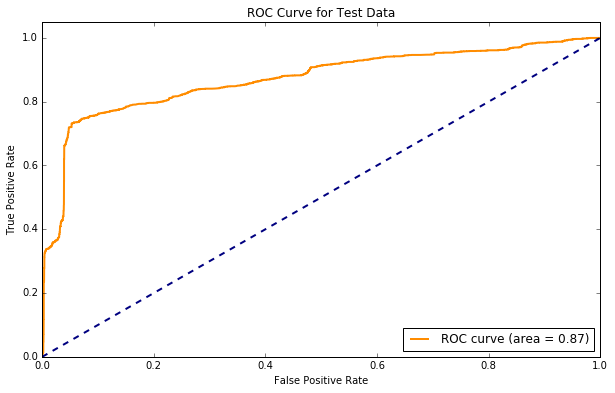

In [95]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
trueTestLabel = test_data.actionable.tolist()
trueTestProb = normalized

fpr, tpr, thresholds = metrics.roc_curve(trueTestLabel, trueTestProb)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for Test Data')
plt.show()

In [98]:
### Confusion Matrix


metrics.confusion_matrix(trueTestLabel, y_pred)

array([[8460, 5566],
       [ 343, 2265]])

In [105]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()



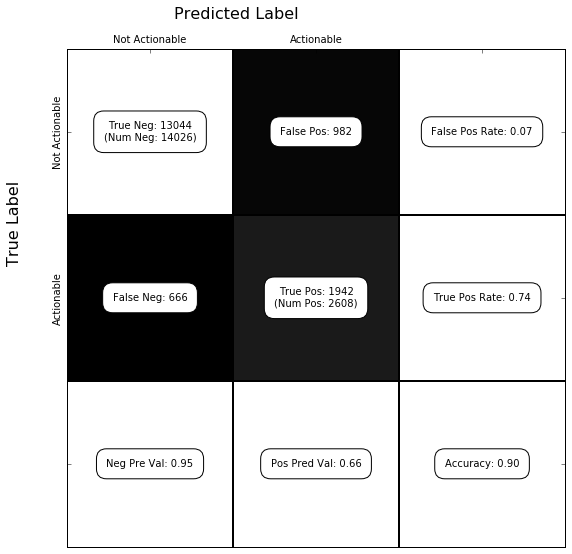

In [106]:
threshold = .9
y_pred = [1 if x > threshold else 0 for x in normalized]
C = confusion_matrix(trueTestLabel,y_pred)
show_confusion_matrix(C, ['Not Actionable', 'Actionable'])